In [1]:
#@title Data retrieval and loading
import os
data_fname = 'stringer_spontaneous.npy'
if data_fname not in os.listdir():
  !wget -qO $data_fname https://osf.io/dpqaj/download

In [2]:
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM'])



dat has fields:
* dat['sresp']: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* dat['run']: timebins by 1, a.k.a. the running speed of the animal in a.u.
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['pupilArea']: timebins by 1, see FaceMap for details on the pupil tracker
* dat['pupilCOM']: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* dat['beh_svd_time']: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* dat['beh_svd_mask']: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]:  reconstruction of the face movie (its motion energy) for frame T

In [3]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [4]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

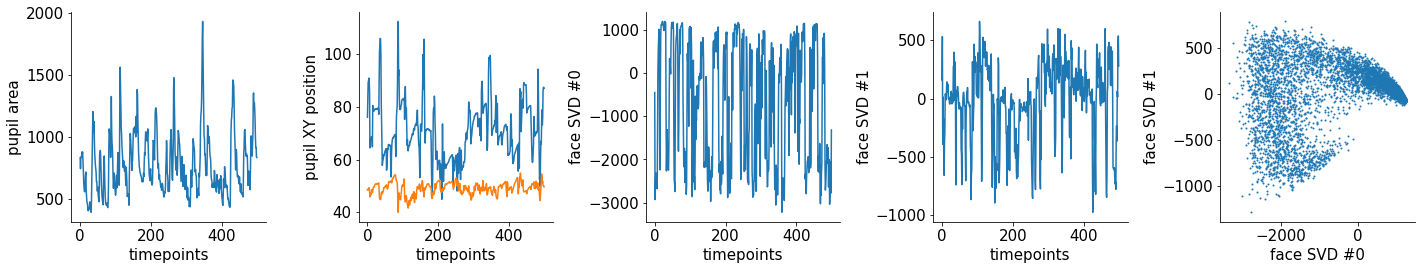

In [5]:
#@title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1,5,1)
plt.plot(dat['pupilArea'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(1,5,2)
plt.plot(dat['pupilCOM'][:500,:])
ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

ax = plt.subplot(1,5,3)
plt.plot(dat['beh_svd_time'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

ax = plt.subplot(1,5,4)
plt.plot(dat['beh_svd_time'][:500,1])
ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

ax = plt.subplot(1,5,5)
plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

plt.show()

In [6]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

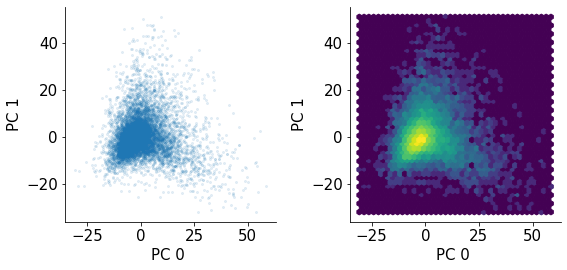

In [7]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
ax = plt.subplot(1,5,1)
plt.scatter(X[:,0], X[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(X[:,0], X[:,1], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [8]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 15, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)
             

/opt/hostedtoolcache/Python/3.7.7/x64/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
from scipy.ndimage import uniform_filter1d
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis = 1)

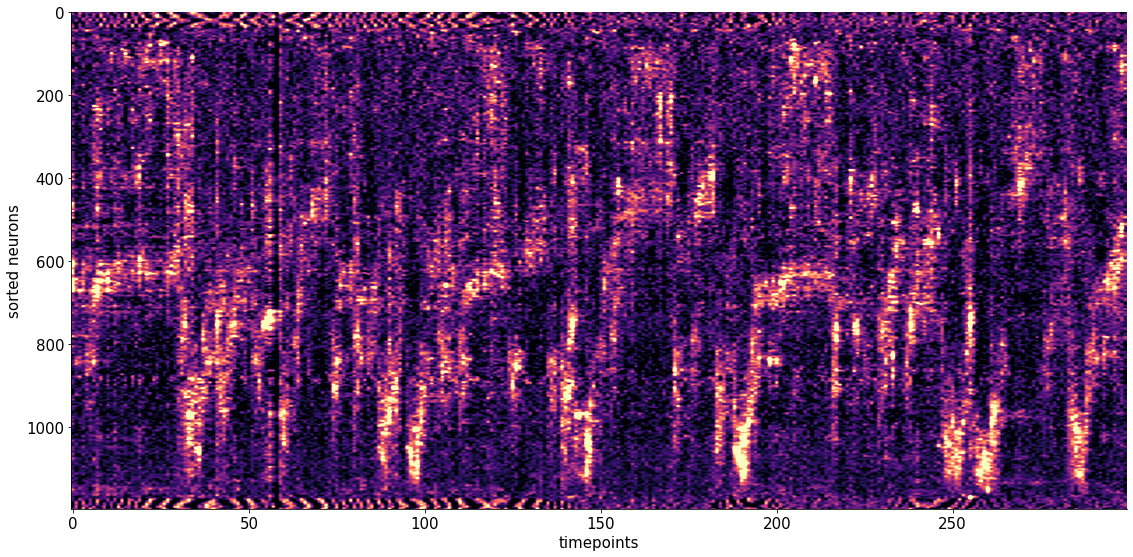

In [10]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

In [11]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture 